In [1]:
##Implementation of SVR
import numpy as np
import pandas as pd
import os
import csv
from collections import defaultdict
import statsmodels.formula.api as sm
from datetime import datetime
import matplotlib.pyplot as plt

path = os.getcwd()

In [2]:
#create a variable for season
def season(row):
    if row['month'] < 3:
        val = 'winter'
    elif row['month'] < 6:
        val = 'spring'
    elif row['month'] < 9:
        val = 'summer'
    elif row['month'] < 12:
        val = 'fall'
    else:
        val = 'winter'   
    return val

def preprocess(dataframe):
    dataframe['season'] = dataframe.apply(season, axis=1)
    dataframe['month'] = dataframe['month'].astype(object)
    dataframe['hour'] = dataframe['hour'].astype(object)
    dataframe['year'] = dataframe['year'].astype(object)
    dataframe = pd.get_dummies(dataframe)
    del dataframe['id']
    del dataframe['day']
    return dataframe

In [11]:
df

,zone,totDay,weekday,w1,w2,w3,w4,w5,w6,w7,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,season_fall,season_spring,season_summer,season_winter
0,1,0,1,46,38,44,45,42,44,45,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,46,36,42,43,42,43,44,...,0,0,0,0,0,0,0,0,0,1
2,1,0,1,45,35,40,41,40,42,41,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,41,30,36,37,39,38,40,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1,39,30,34,33,40,38,35,...,0,0,0,0,0,0,0,0,0,1
5,1,0,1,35,29,32,32,41,37,35,...,0,0,0,0,0,0,0,0,0,1
6,1,0,1,33,28,30,30,38,36,33,...,0,0,0,0,0,0,0,0,0,1
7,1,0,1,33,28,30,29,33,36,30,...,0,0,0,0,0,0,0,0,0,1
8,1,0,1,36,28,30,30,36,38,31,...,0,0,0,0,0,0,0,0,0,1
9,1,0,1,47,33,32,41,43,44,39,...,0,0,0,0,0,0,0,0,0,1


In [3]:
df = pd.read_csv(path + '/GEFCOM/mod_data.csv')
df = preprocess(df)

solutions = pd.read_csv(path + '/GEFCOM/solutions_for_svr.csv')

In [4]:
loadZones = {}
###Separate by load zone
for zone, df_zone in df.groupby('zone'):
    loadZones[zone] = df_zone
    
solZones = {}
for zone, sol_zone in solutions.groupby('zone'):
    solZones[zone] = sol_zone

In [5]:
xTrain = np.array(loadZones[1].drop('load', axis=1))
yTrain = np.array(loadZones[1]['load'])
xTest = np.array(solZones[1].drop('load', axis=1))
yTest = np.array(solZones[1]['load'])
mean = np.mean(xTrain)
std = np.std(xTrain)
xTrain = (xTrain - mean)/std
xTest = (xTest - mean)/std

In [6]:
xTrain.shape, xTest.shape

((38070, 59), (1344, 59))

In [10]:
#train the model for zone 1 (as a test)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

#### Fit SVM regression model
# RBF Kernel
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#y_rbf = svr_rbf.fit(xTrain, yTrain)

# RBF Kernel 2
#svr_rbf2 = SVR(kernel='rbf', C=1e3, gamma=0.15)
#y_rbf2 = svr_rbf2.fit(xTrain, yTrain)

# RBF Kernel 3
#svr_rbf3 = SVR(kernel='rbf', C=1e3, gamma=0.2)
#y_rbf3 = svr_rbf3.fit(xTrain, yTrain)


# Linear Kernel
svr_lin = SVR(kernel='linear', C=1e2)
y_lin = svr_lin.fit(xTrain, yTrain)

In [46]:
# RBF Kernel 3
svr_rbf3 = SVR(kernel='rbf', C=1e-3, gamma=0.2)
y_rbf3 = svr_rbf3.fit(xTrain, yTrain)

In [56]:
# Sigmoid kernel
svrSig = SVR(kernel='sigmoid', C=1e-3)
sigFit = svrSig.fit(xTrain, yTrain)

In [ ]:
# polynomial kerenl kernelaws ssm describe-instance-information --output text --query "InstanceInformationList[*]"
svrPoly = SVR(kernel='poly', C=1e-2)
polyFit = svrPoly.fit(xTrain, yTrain)

In [8]:
ypred = y_lin.predict(xTest)
sqrt((mean_squared_error(y_lin.predict(xTest), yTest)))

8906.218413492243

In [51]:
ypredrbf3 = y_rbf3.predict(xTest)
sqrt((mean_squared_error(y_rbf3.predict(xTest), yTest)))

6236.097682552576

In [57]:
ypredSig = sigFit.predict(xTest)
sqrt((mean_squared_error(ypredSig, yTest)))

6236.097488461452

In [93]:
y_lin.predict(np.reshape(np.array([100000000000]+[50]*58), (1,59)))

array([ 17209.43536601])

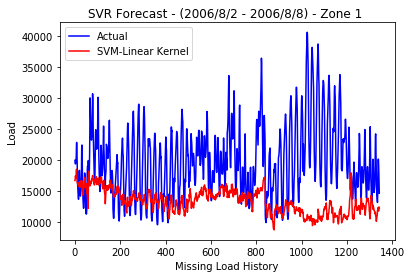

In [9]:

#############################################################################
# Plot SVM Forecast
plt.clf()
plt.plot(yTest, color='Blue', label='Actual')
#plt.plot(y_rbf, color='darkorange', label='SVM-RBF Model 1')
#plt.plot(ypredSig[:168], color='Green', label='SVM-RBF Model 2')
#plt.plot(ypredrbf3[:168], color='Purple', label='SVM-RBF Model 3')
plt.plot(ypred, color='Red', label='SVM-Linear Kernel')
plt.xlabel('Missing Load History')
plt.ylabel('Load')
plt.title('SVR Forecast - (2006/8/2 - 2006/8/8) - Zone 1 ')
plt.legend()
plt.show()


In [67]:

#############################################################################
# Plot SVM Forecast
plt.clf()
plt.plot(yTrain[:168], color='Blue', label='Actual')
#plt.plot(y_rbf, color='darkorange', label='SVM-RBF Model 1')
#plt.plot(ypredSig[:168], color='Green', label='SVM-RBF Model 2')
#plt.plot(ypredrbf3[:168], color='Purple', label='SVM-RBF Model 3')
plt.plot(sigFit.predict(xTrain)[:168], color='Red', label='SVM-Linear Kernel')
plt.xlabel('Missing Load History')
plt.ylabel('Load')
plt.title('SVR Forecast - (2006/8/2 - 2006/8/8) - Zone 1 ')
plt.legend()
plt.show()


KeyboardInterrupt: 